In [ ]:
!pip install konlpy
!pip install googletrans==3.1.0a0

In [ ]:
import pandas as pd
import re
import konlpy
import wordcloud
import os
import gensim
from konlpy.tag import Komoran
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
translator = Translator()
komoran = Komoran(userdic = "/content/drive/MyDrive/graduation/komoran_dict.txt") #기본사전 + 사용자사전

stopwords_path = "/content/drive/MyDrive/graduation/stopwords.txt"

with open(stopwords_path, encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [w.strip() for w in stopwords]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/graduation/all_fold.csv')

In [ ]:
#1. 이상치 제거

In [ ]:
#이상치 기준 설정 함수
'''
1. 띄어쓰기 없앰
2. 알파벳, 중국어(한자), 일본어(히라가나, 가타가나), 아랍어, 그리고 한국어 음절을 제외한 다른 숫자/기호/글자 제거
3. 그 상태에서 문자열의 길이(글자 개수) 측정
'''

def outlier(text):
  text = re.sub(r'[^a-zA-Z가-힇ぁ-ゔァ-ヴー々〆〤一-龥\u0600-\u06FF]','',text)
  length = len(text)
  return length

In [ ]:
outlier('صراحة هاتف رائع يستحق الشراء	')

24

In [ ]:
outlier('나는 abc 靑年 カメラ ㅋㅋㅋ 012')

10

In [ ]:
df['length'] = df['REPLY'].apply(lambda x: outlier(str(x)))

In [ ]:
df

,REPLY,length
0,왜 모든걸 다할수있게 만들어놓고 외장메모리를 못쓰게해놨을까요ㅜㅠ10년간 갤럭시 주구...,418
1,이번 폴드와 플립 완성도가 상당히 높다 생각됩니다.시장에 영향이 있을정도로 많이 팔...,61
2,1년 뒤에 폴드4가 나오면 그땐 정말 완성형이 되지 않을까요? 이번에 폴드2 쓰다가...,104
3,"판매량이 폴더시리즈 역대급 이네요. 없어서 못 팔 지경이라니, 앞으로 새로운 생태계...",52
4,역시 장단점을 고르게 언급해주셨네요.믿고 보는 잇섭!다만 핸드폰이 패드겸용으로 사용...,283
...,...,...
9998,안녕하세요,5
9999,대구,2
10000,올해부터는 낚시는 그만히세요,12
10001,개인적으로 아직까지는 바 형태의 스마트폰이 낫지 않나 싶어요. 폴드는 너무 두껍고 ...,161


In [ ]:
df['length'].describe()

count    10003.000000
mean        36.899030
std         58.475878
min          0.000000
25%         12.000000
50%         22.000000
75%         41.000000
max       2003.000000
Name: length, dtype: float64

In [ ]:
print(df['length'].skew()) #왼쪽으로 너무 치우침

10.799660308612857


In [ ]:
print(df['length'].kurtosis()) #너무 뾰족함

229.28101988447048


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


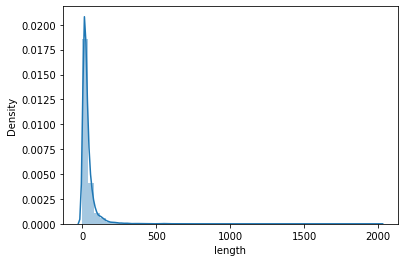

In [ ]:
sns.distplot(df['length']) #정규분포를 이루지 않고 왼쪽으로 너무 치우쳐 있음 -> 데이터 정규화 과정이 필요함

In [ ]:
df['log_length'] = np.log1p(df['length']) #데이터를 로그변환함 -> log(x+1)

In [ ]:
df['log_length'].describe()

count    10003.000000
mean         3.160514
std          0.947888
min          0.000000
25%          2.564949
50%          3.135494
75%          3.737670
max          7.602900
Name: log_length, dtype: float64

In [ ]:
print(df['log_length'].skew()) #거의 대칭을 이룸

-0.011720461372823


In [ ]:
print(df['log_length'].kurtosis()) # 전보다는 정규분포 모양에 가까운 뾰족함

0.8693054124667534


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


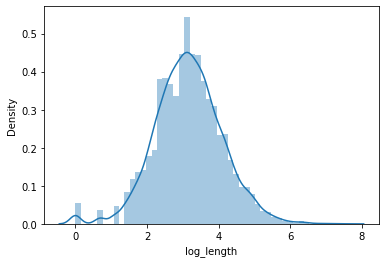

In [ ]:
sns.distplot(df['log_length']) #그래프상으로도 정규분포 모양과 가까워짐을 확인

In [ ]:
q1, q3 =np.percentile(df['log_length'],[25,75])

q1 #제1사분위수

q3 #제3사분위수

iqr = q3-q1 #사분위수 범위

lower_bound = q1 - (iqr*1.5) # Q1 - (iqr * 1.5) #이상치 기준점

lower_bound #정보가 적은 댓글만 제거할 것이므로 lower_bound만 필요함.

0.8058689662287892

In [ ]:
outlier_df = df[df['log_length']<=lower_bound]
outlier_df.sample(5)

,REPLY,length,log_length
3988,?,0,0.000000
1529,ㄷㄷ,0,0.000000
2144,1등,1,0.693147
1359,ㅋㅋ,0,0.000000
8392,❤️,0,0.000000


In [ ]:
new_df = df[df['log_length']>lower_bound] #lower_bound보다 낮은 수치의 데이터를 삭제
new_df.index = [i for i in range(len(new_df))]
new_df #이상치를 제거한 데이터

,REPLY,length,log_length
0,왜 모든걸 다할수있게 만들어놓고 외장메모리를 못쓰게해놨을까요ㅜㅠ10년간 갤럭시 주구...,418,6.037871
1,이번 폴드와 플립 완성도가 상당히 높다 생각됩니다.시장에 영향이 있을정도로 많이 팔...,61,4.127134
2,1년 뒤에 폴드4가 나오면 그땐 정말 완성형이 되지 않을까요? 이번에 폴드2 쓰다가...,104,4.653960
3,"판매량이 폴더시리즈 역대급 이네요. 없어서 못 팔 지경이라니, 앞으로 새로운 생태계...",52,3.970292
4,역시 장단점을 고르게 언급해주셨네요.믿고 보는 잇섭!다만 핸드폰이 패드겸용으로 사용...,283,5.648974
...,...,...,...
9859,안녕하세요,5,1.791759
9860,대구,2,1.098612
9861,올해부터는 낚시는 그만히세요,12,2.564949
9862,개인적으로 아직까지는 바 형태의 스마트폰이 낫지 않나 싶어요. 폴드는 너무 두껍고 ...,161,5.087596


In [ ]:
new_df['REPLY'] = new_df['REPLY'].apply(lambda x: str(x))
new_df['length'] = new_df['length'].apply(lambda x: int(x))
new_df['log_length'] = new_df['log_length'].apply(lambda x: float(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
new_df

,REPLY,length,log_length
0,왜 모든걸 다할수있게 만들어놓고 외장메모리를 못쓰게해놨을까요ㅜㅠ10년간 갤럭시 주구...,418,6.037871
1,이번 폴드와 플립 완성도가 상당히 높다 생각됩니다.시장에 영향이 있을정도로 많이 팔...,61,4.127134
2,1년 뒤에 폴드4가 나오면 그땐 정말 완성형이 되지 않을까요? 이번에 폴드2 쓰다가...,104,4.653960
3,"판매량이 폴더시리즈 역대급 이네요. 없어서 못 팔 지경이라니, 앞으로 새로운 생태계...",52,3.970292
4,역시 장단점을 고르게 언급해주셨네요.믿고 보는 잇섭!다만 핸드폰이 패드겸용으로 사용...,283,5.648974
...,...,...,...
9859,안녕하세요,5,1.791759
9860,대구,2,1.098612
9861,올해부터는 낚시는 그만히세요,12,2.564949
9862,개인적으로 아직까지는 바 형태의 스마트폰이 낫지 않나 싶어요. 폴드는 너무 두껍고 ...,161,5.087596


In [ ]:
new_df.to_csv('/content/drive/MyDrive/graduation/new_df_fold.csv',index=False)

In [ ]:
pd.read_csv('new_df_fold.csv', lineterminator='\n')

,REPLY,length,log_length
0,왜 모든걸 다할수있게 만들어놓고 외장메모리를 못쓰게해놨을까요ㅜㅠ10년간 갤럭시 주구...,418,6.037871
1,이번 폴드와 플립 완성도가 상당히 높다 생각됩니다.시장에 영향이 있을정도로 많이 팔...,61,4.127134
2,1년 뒤에 폴드4가 나오면 그땐 정말 완성형이 되지 않을까요? 이번에 폴드2 쓰다가...,104,4.653960
3,"판매량이 폴더시리즈 역대급 이네요. 없어서 못 팔 지경이라니, 앞으로 새로운 생태계...",52,3.970292
4,역시 장단점을 고르게 언급해주셨네요.믿고 보는 잇섭!다만 핸드폰이 패드겸용으로 사용...,283,5.648974
...,...,...,...
9859,안녕하세요,5,1.791759
9860,대구,2,1.098612
9861,올해부터는 낚시는 그만히세요,12,2.564949
9862,개인적으로 아직까지는 바 형태의 스마트폰이 낫지 않나 싶어요. 폴드는 너무 두껍고 ...,161,5.087596
